# Investigating Cov. Shift and Concept Drift in time

In [49]:
from functions import *

In [50]:
ids0=list(pd.read_csv('data/ids_t0.csv').ndoc)
parts = partition(ids0.copy(), m)

In [51]:
cpus=20

In [52]:
data={}

for i in tqdm(range(m)):
    X=pd.read_csv('data/X_t'+str(i)+'.csv').iloc[:,:num_feat[-1]]
    y=pd.read_csv('data/y_t'+str(i)+'.csv')
    ids=list(pd.read_csv('data/ids_t'+str(i)+'.csv').ndoc)
    
    pool = mp.Pool(cpus)
    ind = np.array(pool.starmap(check, [(j, parts[i]) for j in ids]))
    pool.close()
    
    X=X.loc[ind,:] 
    y=y.loc[ind]

    ind=np.mean((X==-2) | (X==-1), axis=1)<.75
    X=X.loc[ind,:].reset_index(drop=True) 
    y=y.loc[ind].reset_index(drop=True)
    
    if i==0:
        n=X.shape[0]

    X=X.iloc[:n,:]
    y=y.iloc[:n]
    
    data[i]={'X': X,'y': y}

100%|██████████| 10/10 [28:43<00:00, 172.34s/it]


In [53]:
for i in range(m):
    print('Month={:}, X.shape={:}'.format(i+1, data[i]['X'].shape))

Month=1, X.shape=(54044, 75)
Month=2, X.shape=(54044, 75)
Month=3, X.shape=(54044, 75)
Month=4, X.shape=(54044, 75)
Month=5, X.shape=(54044, 75)
Month=6, X.shape=(54044, 75)
Month=7, X.shape=(54044, 75)
Month=8, X.shape=(54044, 75)
Month=9, X.shape=(54044, 75)
Month=10, X.shape=(54044, 75)


In [54]:
def simulation2(b, data):
    num_feat=[1, 2, 3, 5, 10, 15, 25, 50, 75]
    
    #Outputs
    p_est=[]
    p_err=[]
    
    #Splitting data
    for i in range(m):
        data[i][b]={}
        data[i][b]['X_train'], data[i][b]['X_test'], data[i][b]['y_train'], data[i][b]['y_test'] = train_test_split(data[i]['X'], data[i]['y'], test_size=.1, stratify=data[i]['y'], random_state=b)
        data[i][b]['X_train'], data[i][b]['X_val'], data[i][b]['y_train'], data[i][b]['y_val'] = train_test_split(data[i][b]['X_train'], data[i][b]['y_train'], test_size=.1, stratify=data[i][b]['y_train'], random_state=b)
        
    #For each number of features we make
    for k in num_feat:
        
        if b==0:
            print(k)
        
        ##### estimating delta prob #####
        models=[]
        p_fact=[]
        p_cfact=[]
            
        for i in range(m):
            X = data[i][b]['X_train'].iloc[:,:k]
            y = data[i][b]['y_train'].squeeze()
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=b)
            models.append(train_model(X_train, y_train, X_val, y_val, b))
            
        for i in range(m):
            p_fact.append(models[i].predict_proba(data[i][b]['X_test'].iloc[:,:k])[:,1])
            p_cfact.append(models[0].predict_proba(data[i][b]['X_test'].iloc[:,:k])[:,1])

        ##### storing #####
        
        p_fact_est = [np.mean(d) for d in p_fact]
        p_fact_err = [np.std(np.array(d))/np.sqrt(len(d)) for d in p_fact]
        p_cfact_est = [np.mean(d) for d in p_cfact]
        p_cfact_err = [np.std(np.array(d))/np.sqrt(len(d)) for d in p_cfact]
        
        p_est.append([p_fact_est, p_cfact_est])
        p_err.append([p_fact_err, p_cfact_err])

    return [p_est, p_err]

In [55]:
%%time
B=75

pool = mp.Pool(cpus)
out = pool.starmap(simulation2, [(b, data) for b in range(B)])
pool.close()

1
2
3
5
10
15
25
50
75
CPU times: user 30.7 s, sys: 44.1 s, total: 1min 14s
Wall time: 35min 37s


In [56]:
#(simulations, shift_est/err, num_feat, total/cov/conc, months)
out=np.array(out)
out.shape

(75, 2, 9, 2, 10)

In [57]:
np.save('outputs_p_notuning.npy', out) 

In [58]:
out = np.load('outputs_p_notuning.npy', allow_pickle='TRUE')
out.shape

(75, 2, 9, 2, 10)

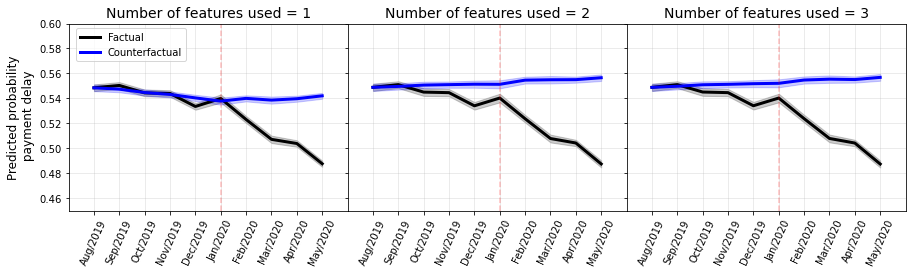

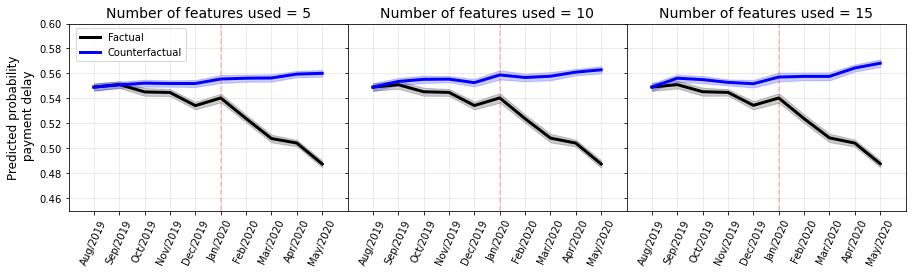

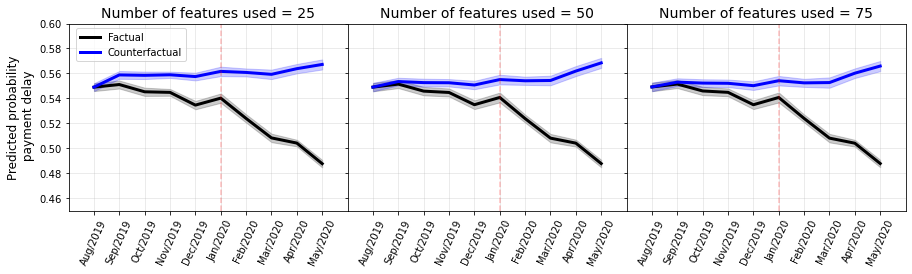

In [59]:
for j in range(3):
    
    fig, axs = plt.subplots(1, 3, sharey=True)
    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.0   # the amount of width reserved for blank space between subplots
    hspace = 0.2   # the amount of height reserved for white space between subplots
    plt.subplots_adjust(left, bottom, right, top, wspace, hspace)

    for i in range(3):
        
        f=3*j+i
        p_fact_mean, p_cfact_mean = [np.mean(out[:, 0, f, s, :], axis=0) for s in range(2)]
        p_fact_std, p_cfact_std = [np.std(out[:, 0, f, s, :], axis=0) for s in range(2)]
        
        #
        axs[i].plot(np.arange(m), p_fact_mean, color='k', ls='-', lw=3, label='Factual')
        axs[i].fill_between(np.arange(m), p_fact_mean-p_fact_std, p_fact_mean+p_fact_std, color='k', alpha=0.2)
        axs[i].plot(np.arange(m), p_cfact_mean, color='b', ls='-', lw=3, label='Counterfactual')
        axs[i].fill_between(np.arange(m), p_cfact_mean-p_cfact_std, p_cfact_mean+p_cfact_std, color='b', alpha=0.2)

        axs[i].axhline(y=0, color='r', linestyle='-', lw=1.5, alpha=.25)
        axs[i].axvline(x=5, color='r', linestyle='--', lw=1.5, alpha=.25)
        #

        axs[i].set_title('Number of features used = '+str(num_feat[3*j+i]), size=14)
        #axs[i].set_xlabel('Months', size=12)
        if i==0:
            axs[i].legend(bbox_to_anchor=(.025, .975), loc='upper left', borderaxespad=.0)
            axs[i].set_ylabel("Predicted probability\n payment delay", size=12)
            axs[i].yaxis.set_tick_params(which='both', labelbottom=True)
            
           
        axs[i].set_xticks([0,1,2,3,4,5,6,7,8,9])
        axs[i].set_xticklabels(['Aug/2019', 'Sep/2019', 'Oct/2019', 'Nov/2019', 'Dec/2019','Jan/2020', 'Feb/2020', 'Mar/2020', 'Apr/2020', 'May/2020'], rotation=65)
        axs[i].set_xlim((-1,10))
        axs[i].set_ylim((0.45,.6))
        
        axs[i].grid(alpha=.3)
        
 
    fig.set_figheight(3.25)
    fig.set_figwidth(15)
    plt.savefig('plots/p'+str(j)+'_notuning.png', bbox_inches='tight', dpi=300, transparent=True)

In [44]:
for i in range(10):
    print(data[i]['y'].mean())

SConcEver30dP3_100    0.549128
dtype: float64
SConcEver30dP3_100    0.550195
dtype: float64
SConcEver30dP3_100    0.546774
dtype: float64
SConcEver30dP3_100    0.544898
dtype: float64
SConcEver30dP3_100    0.537485
dtype: float64
SConcEver30dP3_100    0.540134
dtype: float64
SConcEver30dP3_100    0.525327
dtype: float64
SConcEver30dP3_100    0.50092
dtype: float64
SConcEver30dP3_100    0.504782
dtype: float64
SConcEver30dP3_100    0.486371
dtype: float64


In [47]:
for i in range(m):
    y=pd.read_csv('data/y_t'+str(i)+'.csv')
    print(y.mean())

SConcEver30dP3_100    0.573428
dtype: float64
SConcEver30dP3_100    0.57406
dtype: float64
SConcEver30dP3_100    0.570449
dtype: float64
SConcEver30dP3_100    0.570469
dtype: float64
SConcEver30dP3_100    0.560831
dtype: float64
SConcEver30dP3_100    0.563994
dtype: float64
SConcEver30dP3_100    0.55119
dtype: float64
SConcEver30dP3_100    0.531872
dtype: float64
SConcEver30dP3_100    0.531861
dtype: float64
SConcEver30dP3_100    0.514423
dtype: float64
